# COMP4318/COMP5318 Bloodcell Classification





# Setup

In [53]:
# Please include your imports in this cell

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam
import pandas as pd

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


def plot_examples(data, n_rows=1, n_cols=3):
    
    # Remove redundant extra dimension
    if data.shape[-1] == 1:
        data = data.squeeze(axis=-1)
        
    
    # Size figure depending on the size of the grid
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    
    for row in range(n_rows):
        for col in range(n_cols):
            
            # Get next index of image
            index = n_cols * row + col
            
            # Plot the image at appropriate place in grid
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(data[index], cmap="binary")
            plt.axis('off')
            
    plt.show()

def plot_examples_MLP_LR(images, labels, n_rows=1, n_cols=5):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*1.2, n_rows*1.2))
    axes = axes.ravel()
    
    for i in range(n_rows * n_cols):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    
    
def plot_cnn(data,y_pred, n_rows=1, n_cols=3):
    
    # Remove redundant extra dimension
    if data.shape[-1] == 1:
        data = data.squeeze(axis=-1)
        
    
    # Size figure depending on the size of the grid
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    
    for row in range(n_rows):
        for col in range(n_cols):
            
            # Get next index of image
            index = n_cols * row + col
            
            # Plot the image at appropriate place in grid
            plt.subplot(n_rows, n_cols, index + 1)
            plt.title(f"Class: {y_pred[index]}")
            plt.imshow(data[index], cmap="binary")
            plt.axis('off')
            
    plt.show()
    
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Data loading, exploration, and preprocessing

## Data loading

In [54]:
# Load data files assuming Assignment2Data folder 
# is present in the same directory as the notebook

#One for cnn, One for other model
X_train_cnn = np.load('Assignment2Data/X_train.npy')
y_train_cnn = np.load('Assignment2Data/y_train.npy')
X_test_cnn = np.load('Assignment2Data/X_test.npy')
y_test_cnn = np.load('Assignment2Data/y_test.npy')

X_train_full = np.load('Assignment2Data/X_train.npy')
y_train_full = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')
X_test_sample = np.load('Assignment2Data/X_test.npy')

## Data exploration

In [55]:
#print the shape
print(f'X_test_cnn shape: {X_test_cnn.shape}')
print(f'X_train_cnn shape: {X_train_cnn.shape}')
print(f'y_test_cnn shape: {y_test_cnn.shape}')
print(f'y_train_cnn shape: {y_train_cnn.shape}')

print(f'X_test shape: {X_test.shape}')
print(f'X_train_full shape: {X_train_full.shape}')
print(f'y_test shape: {y_test.shape}')
print(f'y_train_full shape: {y_train_full.shape}')

X_test_cnn shape: (3419, 28, 28, 3)
X_train_cnn shape: (13673, 28, 28, 3)
y_test_cnn shape: (3419,)
y_train_cnn shape: (13673,)
X_test shape: (3419, 28, 28, 3)
X_train_full shape: (13673, 28, 28, 3)
y_test shape: (3419,)
y_train_full shape: (13673,)


In [56]:
#Print the range of pixel values
print(f'Max pixel value in X_train_full: {np.max(X_train_full)}')
print(f'Min pixel value in X_train_full: {np.min(X_train_full)}')
print(f'Max pixel value in X_test: {np.max(X_test)}')
print(f'Min pixel value in X_test: {np.min(X_test)}')

print(f'Max pixel value in X_train_cnn: {np.max(X_train_cnn)}')
print(f'Min pixel value in X_train_cnn: {np.min(X_train_cnn)}')
print(f'Max pixel value in X_test_cnn: {np.max(X_test_cnn)}')
print(f'Min pixel value in X_test_cnn: {np.min(X_test_cnn)}')

Max pixel value in X_train_full: 255
Min pixel value in X_train_full: 0
Max pixel value in X_test: 255
Min pixel value in X_test: 0
Max pixel value in X_train_cnn: 255
Min pixel value in X_train_cnn: 0
Max pixel value in X_test_cnn: 255
Min pixel value in X_test_cnn: 0


In [57]:
# Print the labels and figure out the unique labels
print("Training labels:")
print(y_train_full)

print("Test labels:")
print(y_test)

unique_train_labels, counts_train_labels = np.unique(y_train_full, return_counts=True)
unique_test_labels, counts_test_labels = np.unique(y_test, return_counts=True)

print("Unique labels of training data:")
print(unique_train_labels)

print("Unique labels of test data:")
print(unique_test_labels)

Training labels:
[7 3 4 ... 4 6 3]
Test labels:
[1 0 3 ... 0 3 3]
Unique labels of training data:
[0 1 2 3 4 5 6 7]
Unique labels of test data:
[0 1 2 3 4 5 6 7]


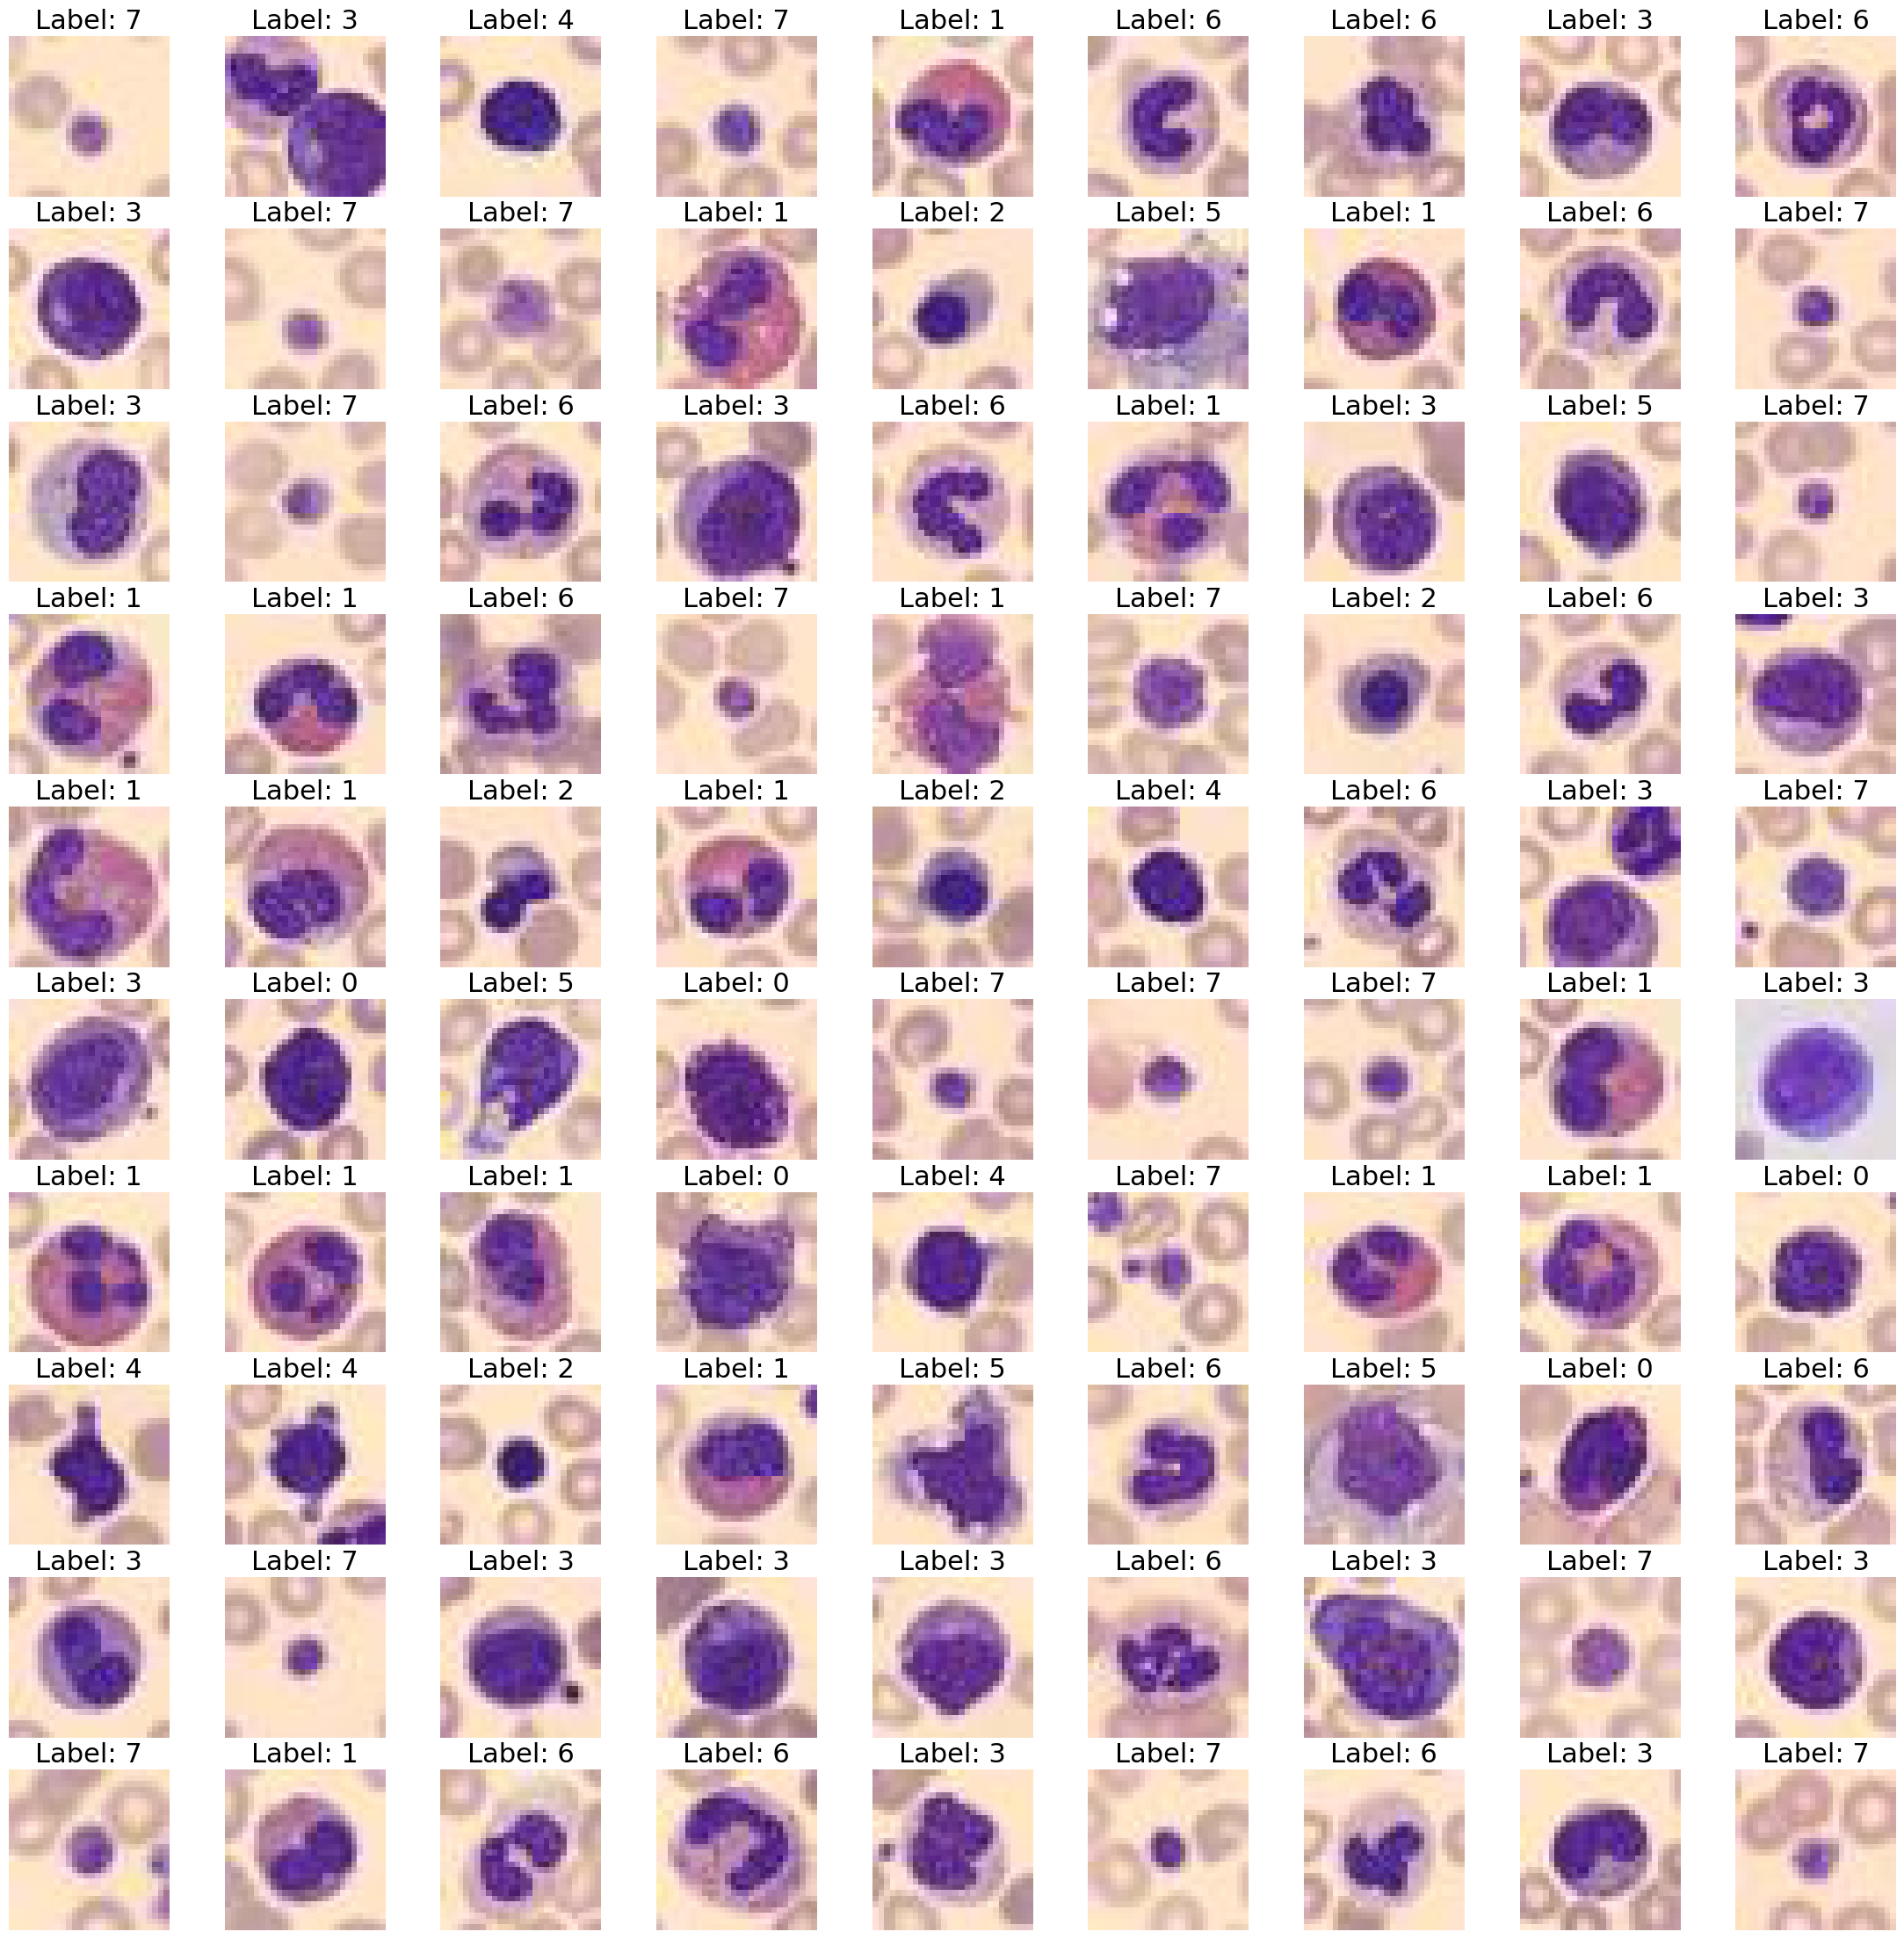

In [58]:
# Print 90 pictures from the dataset with their labels shown in the title.
plt.figure(figsize=(28,28))
for i in range(90):
  plt.subplot(10,9,i+1)
  plt.imshow(X_train_full[i],cmap="binary")
  plt.title(f"Label: {y_train_full[i]}", fontsize=22)
  plt.axis("off")

## Preprocessing

In [59]:
#Normalization
X_train_N_cnn = X_train_cnn / 255.0
X_test_N_cnn = X_test_cnn / 255.0
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

In [60]:
#Data Augmentation
#https://medium.com/@bcwalraven/boost-your-cnn-with-the-keras-imagedatagenerator-99b1ef262f47
# I go through this link to get some idea for Data Augmentation.

train_datagen = ImageDataGenerator(
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=45,
                                   horizontal_flip=True,
                                   vertical_flip=True)

train_datagen.fit(X_train_N_cnn)

In [61]:
# Create validation set from the training set
X_train_cnn, X_valid_cnn, y_train_cnn, y_valid_cnn = train_test_split(X_train_N_cnn, y_train_cnn, train_size=0.85)

#Split dataset
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.85)


print(f"Shape of X_train_cnn: {X_train_cnn.shape}")
print(f"Shape of X_train_cnn: {X_train.shape}")

Shape of X_train_cnn: (11622, 28, 28, 3)
Shape of X_train_cnn: (11622, 28, 28, 3)


In [62]:
#Flatten data
X_train = X_train.reshape((X_train.shape[0], -1))
X_valid = X_valid.reshape((X_valid.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

In [63]:
# Data transform Principal Component Analysis
pca = PCA(n_components = 0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_valid_pca = pca.transform(X_valid)

## Examples of preprocessed data
Please print/display some examples of your preprocessed data here. 

In [64]:
# 1. Example of Flattened X_test
X_test.shape

(3419, 2352)

In [65]:
# 2. Example of X_test_pca
X_test_pca.shape

(3419, 177)

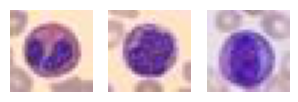

In [66]:
# 3. Example images from X_test_cnn
plot_examples(X_test_cnn, n_rows=1, n_cols=3)

# Algorithm design and setup

## Model 1 - Fully Connected Neural Network

In [29]:
# Setting up the MLP model, using one hidden layer
MLP = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(8, activation="softmax")
])
# Choose the optimizer
opt = keras.optimizers.Adam(learning_rate=0.1)
# Compile the MLP model
MLP.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [30]:
# Call MLP model
history = MLP.fit(X_train_pca, y_train, epochs=20,
                    validation_data=(X_valid_pca, y_valid))

Epoch 1/20
364/364 [==============================] - 3s 2ms/step - loss: 2.6796 - accuracy: 0.6396 - val_loss: 2.3911 - val_accuracy: 0.6421
Epoch 2/20
364/364 [==============================] - 0s 1ms/step - loss: 2.0204 - accuracy: 0.6964 - val_loss: 1.4270 - val_accuracy: 0.7143
Epoch 3/20
364/364 [==============================] - 0s 1ms/step - loss: 1.5219 - accuracy: 0.7155 - val_loss: 1.6011 - val_accuracy: 0.7153
Epoch 4/20
364/364 [==============================] - 0s 1ms/step - loss: 1.6506 - accuracy: 0.7268 - val_loss: 2.3063 - val_accuracy: 0.6777
Epoch 5/20
364/364 [==============================] - 0s 1ms/step - loss: 1.4202 - accuracy: 0.7283 - val_loss: 2.1115 - val_accuracy: 0.6909
Epoch 6/20
364/364 [==============================] - 0s 1ms/step - loss: 1.5105 - accuracy: 0.7383 - val_loss: 1.6297 - val_accuracy: 0.7045
Epoch 7/20
364/364 [==============================] - 1s 1ms/step - loss: 1.4512 - accuracy: 0.7303 - val_loss: 1.5472 - val_accuracy: 0.7231
Epoch 

In [31]:
# Evaluate the Accuracy of MLP model
loss, accuracy = MLP.evaluate(X_test_pca, y_test)
print(f"loss: {loss:.4f}")
print(f"Accuracy of MLP: {accuracy:.2f}")

107/107 [==============================] - 0s 1ms/step - loss: 2.2893 - accuracy: 0.7011
loss: 2.2893
Accuracy of MLP: 0.70


## Model 2 - Convolutional Neural Network

In [13]:
# Create CNN model
def create_cnn_model(pool_type='max', conv_activation='relu', dropout_rate= 0.5 ):
    # create model
    model = keras.Sequential()
    
    # Specify the input shape
    model.add(keras.Input(shape=(28, 28, 3))) 
        
    # Conv and pool block 1
    model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation=conv_activation))  
    if pool_type == 'max': # change the poo_type when do the Hyperparameter tuning
        model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    if pool_type == 'average':
        model.add(keras.layers.AveragePooling2D(pool_size=(2, 2)))
    if dropout_rate != 0: # change the dropout_rate when do the Hyperparameter tuning
        model.add(keras.layers.Dropout(rate=dropout_rate))
    
    # Conv and pool block 2
    model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation=conv_activation))   
    if pool_type == 'max':
        model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    if pool_type == 'average':
        model.add(keras.layers.AveragePooling2D(pool_size=(2, 2)))
    if dropout_rate != 0:
        model.add(keras.layers.Dropout(rate=dropout_rate))
      
    # Flatten and classify using dense output layer
    model.add(keras.layers.Flatten())         
    model.add(keras.layers.Dense(256, activation='softmax'))
    if dropout_rate != 0:
        model.add(keras.layers.Dropout(rate=dropout_rate))
        
    
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])  
    return model

cnn = create_cnn_model()

In [16]:
# Train the CNN model
# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
# I go through this link to get some idea for early stopping, then I can has high epochs to run the model and early stop when 
# the Accuracy are not increase in 10 step.
es = EarlyStopping(
    monitor='val_loss',  
    patience=10,         
    restore_best_weights=True  
)

# Train the model for 100 epochs with batch size 128
batch_size = 128
epochs = 100
history = cnn.fit(X_train_cnn,y_train_cnn, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid_cnn, y_valid_cnn), callbacks=[es])

Epoch 1/100
91/91 [==============================] - 8s 10ms/step - loss: 8.0023 - accuracy: 0.1804 - val_loss: 4.6553 - val_accuracy: 0.1945
Epoch 2/100
91/91 [==============================] - 0s 5ms/step - loss: 7.1953 - accuracy: 0.2388 - val_loss: 3.1915 - val_accuracy: 0.3228
Epoch 3/100
91/91 [==============================] - 0s 5ms/step - loss: 6.6365 - accuracy: 0.2799 - val_loss: 3.2404 - val_accuracy: 0.3520
Epoch 4/100
91/91 [==============================] - 0s 5ms/step - loss: 6.4898 - accuracy: 0.2913 - val_loss: 1.9843 - val_accuracy: 0.5373
Epoch 5/100
91/91 [==============================] - 0s 5ms/step - loss: 5.9960 - accuracy: 0.3576 - val_loss: 2.6995 - val_accuracy: 0.6265
Epoch 6/100
91/91 [==============================] - 0s 5ms/step - loss: 5.5212 - accuracy: 0.3797 - val_loss: 2.5513 - val_accuracy: 0.6485
Epoch 7/100
91/91 [==============================] - 0s 5ms/step - loss: 5.3891 - accuracy: 0.3861 - val_loss: 2.2192 - val_accuracy: 0.6802
Epoch 8/100


In [17]:
# Evaluate the classifier on the test data.
loss, accuracy = cnn.evaluate(X_train_cnn, y_train_cnn)
print(f"Accuracy on test data: {accuracy:.4f}")

364/364 [==============================] - 1s 2ms/step - loss: 1.9798 - accuracy: 0.5508
Accuracy on test data: 0.5508


## Model 3 - Algorithm Choice 1

In [34]:
# Call the LR model
LR = LogisticRegression(penalty="l2",C=0.01)
LR.fit(np.concatenate((X_train_pca, X_valid_pca)), np.concatenate((y_train, y_valid)))
print(f"Accuracy of LR: {LR.score(X_test_pca, y_test):.2f}")

Accuracy of LR: 0.78


## Model 4 - Algorithm Choice 2

In [35]:
# Create the random forest model, and train for default setting

rnd_clf = RandomForestClassifier()
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
print("Random forest ensemble - accuracy on test set:")
print(accuracy_score(y_test, y_pred_rf))

Random forest ensemble - accuracy on test set:
0.8303597543141269


# Hyperparameter tuning

## Model 1 - Fully Connected Neural Network

In [39]:
# Building MLP
def build_MLP(n_hidden_layers=2, n_hidden_neurons=50, activation_function="relu", input_shape=[177]):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shape))
    for layer in range(n_hidden_layers):
        model.add(keras.layers.Dense(n_hidden_neurons, activation=activation_function))
    model.add(keras.layers.Dense(8, activation="softmax"))
    return model
# For the purpose of shorten the runtime, codes below used early stopping, so that when the accuracy doesn't increase 
# the search process cease automatically

# Using Grid Search and outputs the best parameter set, also plotting the parameters
def tune_MLP(param_grid, x, y, cv=3, epochs=20, verbose=2):

    keras_classifier = KerasClassifier(build_MLP,
                                       n_hidden_layers=2,
                                       n_hidden_neurons=50,
                                       activation_function="relu",
                                       loss="sparse_categorical_crossentropy",
                                       optimizer="Adam",
                                       optimizer__lr=0.01,
                                       metrics=["accuracy"]
                                      )
    
    
    
    grid_search_cv = GridSearchCV(keras_classifier, param_grid, cv=cv, verbose=verbose)
    grid_search_cv.fit(x, y, epochs=epochs,
                       callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])
    
    
    params = list(param_grid.keys())
    p1, p2 = params

    scores = grid_search_cv.cv_results_['mean_test_score']
    scores = np.array(scores).reshape(len(param_grid[p1]), len(param_grid[p2]))

    total_fit_times = [time * cv for time in grid_search_cv.cv_results_['mean_fit_time']]
    plt.figure(figsize=(10, 6))

    for i, val in enumerate(param_grid[p1]):
        plt.plot(param_grid[p2], scores[i, :], '-o', label=f"{p1}: {val}")

    plt.xlabel(p2)
    plt.ylabel('Average Test Score')
    plt.legend()
    plt.title('Average Test Score By Grid Search')
    plt.grid(True)
    

    plt.show()
    
    for i, (params, runtime) in enumerate(zip(grid_search_cv.cv_results_['params'], total_fit_times)):
        print(f"Param combination {i+1}: {params} took {runtime:.2f} seconds in total for {cv} CV splits")

    print("Best params:")
    print(grid_search_cv.best_params_)
    print()

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Epoch 1/20
243/243 [==============================] - 1s 2ms/step - loss: 0.9272 - accuracy: 0.6963
Epoch 2/20
243/243 [==============================] - 0s 1ms/step - loss: 0.5499 - accuracy: 0.8101
Epoch 3/20
243/243 [==============================] - 0s 2ms/step - loss: 0.4585 - accuracy: 0.8504
Epoch 4/20
243/243 [==============================] - 0s 1ms/step - loss: 0.4083 - accuracy: 0.8720
Epoch 5/20
243/243 [==============================] - 0s 1ms/step - loss: 0.3291 - accuracy: 0.8936
Epoch 6/20
243/243 [==============================] - 0s 1ms/step - loss: 0.2500 - accuracy: 0.9228
Epoch 7/20
243/243 [==============================] - 0s 1ms/step - loss: 0.3048 - accuracy: 0.9090
Epoch 8/20
243/243 [==============================] - 0s 1ms/step - loss: 0.2570 - accuracy: 0.9248
Epoch 9/20
243/243 [==============================] - 0s 1ms/step - loss: 0.2473 - accuracy: 0.9311
Epoch 10/20
243/243 [===================

243/243 [==============================] - 0s 1ms/step - loss: 0.1788 - accuracy: 0.9510
Epoch 14/20
243/243 [==============================] - 0s 1ms/step - loss: 0.1519 - accuracy: 0.9547
Epoch 15/20
243/243 [==============================] - 0s 1ms/step - loss: 0.1394 - accuracy: 0.9627
Epoch 16/20
243/243 [==============================] - 0s 1ms/step - loss: 0.2420 - accuracy: 0.9457
Epoch 17/20
243/243 [==============================] - 0s 1ms/step - loss: 0.2039 - accuracy: 0.9526
Epoch 18/20
243/243 [==============================] - 0s 1ms/step - loss: 0.1886 - accuracy: 0.9555
Epoch 19/20
243/243 [==============================] - 0s 1ms/step - loss: 0.2022 - accuracy: 0.9575
Epoch 20/20
122/122 [==============================] - 0s 671us/step
[CV] END n_hidden_neurons=1200, optimizer__learning_rate=0.0018; total time=   7.2s
Epoch 1/20
243/243 [==============================] - 1s 1ms/step - loss: 0.9266 - accuracy: 0.6945
Epoch 2/20
243/243 [==============================] 

243/243 [==============================] - 0s 1ms/step - loss: 0.2535 - accuracy: 0.9317
Epoch 10/20
243/243 [==============================] - 0s 1ms/step - loss: 0.2276 - accuracy: 0.9432
Epoch 11/20
243/243 [==============================] - 0s 1ms/step - loss: 0.2187 - accuracy: 0.9400
Epoch 12/20
243/243 [==============================] - 0s 1ms/step - loss: 0.1759 - accuracy: 0.9498
Epoch 13/20
243/243 [==============================] - 0s 1ms/step - loss: 0.2097 - accuracy: 0.9459
Epoch 14/20
243/243 [==============================] - 0s 1ms/step - loss: 0.1423 - accuracy: 0.9618
Epoch 15/20
243/243 [==============================] - 0s 1ms/step - loss: 0.1567 - accuracy: 0.9578
Epoch 16/20
243/243 [==============================] - 0s 1ms/step - loss: 0.1562 - accuracy: 0.9561
Epoch 17/20
243/243 [==============================] - 0s 1ms/step - loss: 0.2175 - accuracy: 0.9378
Epoch 18/20
243/243 [==============================] - 0s 1ms/step - loss: 0.2152 - accuracy: 0.9541
Ep

Epoch 5/20
243/243 [==============================] - 0s 1ms/step - loss: 0.3702 - accuracy: 0.8776
Epoch 6/20
243/243 [==============================] - 0s 1ms/step - loss: 0.2673 - accuracy: 0.9165
Epoch 7/20
243/243 [==============================] - 0s 1ms/step - loss: 0.2779 - accuracy: 0.9140
Epoch 8/20
243/243 [==============================] - 0s 1ms/step - loss: 0.3063 - accuracy: 0.9122
Epoch 9/20
243/243 [==============================] - 0s 1ms/step - loss: 0.3065 - accuracy: 0.9215
Epoch 10/20
243/243 [==============================] - 0s 1ms/step - loss: 0.2831 - accuracy: 0.9268
Epoch 11/20
243/243 [==============================] - 0s 1ms/step - loss: 0.1653 - accuracy: 0.9502
Epoch 12/20
243/243 [==============================] - 0s 1ms/step - loss: 0.1447 - accuracy: 0.9566
Epoch 13/20
243/243 [==============================] - 0s 1ms/step - loss: 0.1652 - accuracy: 0.9512
Epoch 14/20
243/243 [==============================] - 0s 1ms/step - loss: 0.2579 - accuracy: 0.

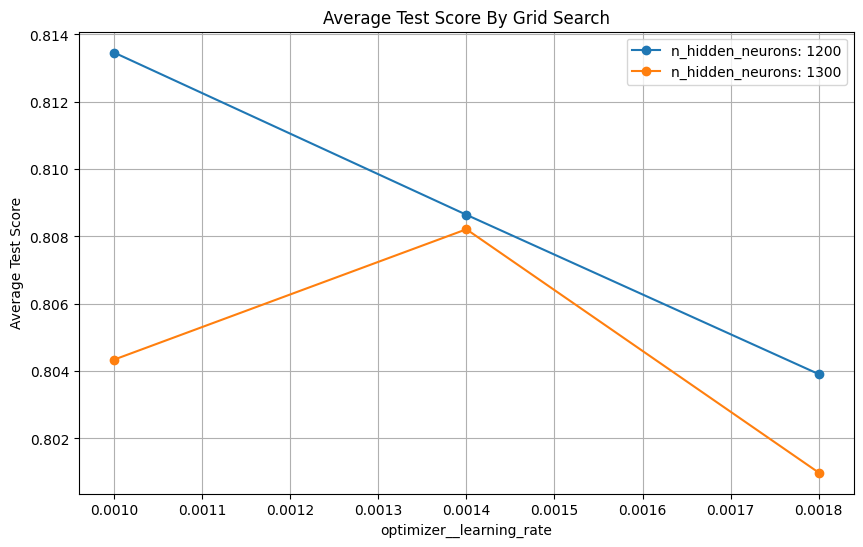

Param combination 1: {'n_hidden_neurons': 1200, 'optimizer__learning_rate': 0.001} took 21.54 seconds in total for 3 CV splits
Param combination 2: {'n_hidden_neurons': 1200, 'optimizer__learning_rate': 0.0014} took 21.72 seconds in total for 3 CV splits
Param combination 3: {'n_hidden_neurons': 1200, 'optimizer__learning_rate': 0.0018} took 21.09 seconds in total for 3 CV splits
Param combination 4: {'n_hidden_neurons': 1300, 'optimizer__learning_rate': 0.001} took 21.42 seconds in total for 3 CV splits
Param combination 5: {'n_hidden_neurons': 1300, 'optimizer__learning_rate': 0.0014} took 21.55 seconds in total for 3 CV splits
Param combination 6: {'n_hidden_neurons': 1300, 'optimizer__learning_rate': 0.0018} took 21.45 seconds in total for 3 CV splits
Best params:
{'n_hidden_neurons': 1200, 'optimizer__learning_rate': 0.001}



In [40]:
# Setting parameters for Grid Search
param_grid = {
    "n_hidden_neurons": [1200, 1300],
    "optimizer__learning_rate": [0.001, 0.0014, 0.0018],
}

grid_result = tune_MLP(param_grid, X_train_pca, y_train)

## Model 2 - Convolutional Neural Network

In [62]:
# create keras classifier
keras_classifier = KerasClassifier(create_cnn_model,
conv_activation="relu",
loss="sparse_categorical_crossentropy",
pool_type='max',
dropout_rate = 0,
metrics=["accuracy"]
)

In [63]:
# set the Hyperparameter we want to test
param_grid = {
"conv_activation": ["relu", "sigmoid", "tanh"],
"optimizer__learning_rate": [0.1, 0.01, 0.005],
"dropout_rate": [0, 0.2, 0.5]
}

In [64]:
# create the grid search function
def grid_search(fun, param_grid):
    clf = GridSearchCV(fun, param_grid, cv=3)
    print("Now testing..."+ type(fun).__name__)
    clf.fit(X_train_cnn, y_train_cnn, epochs=20)
    print("Best params:")
    print(clf.best_params_)
    print()
    return clf

In [65]:
# create the Hyperparameter tunning function for cnn
# That will print the Best params and plot the graph shows use different params accuracy
def cnn_param(param_grid):
    start_time = time.time()
    clf = grid_search(keras_classifier, param_grid)

    test_score = clf.cv_results_["mean_test_score"].reshape(len(param_grid["conv_activation"]),
                                                          len(param_grid["optimizer__learning_rate"]), -1)
    total_time = time.time() - start_time
    total_fit_times = [time * clf.cv for time in clf.cv_results_['mean_fit_time' ]]
    print(f"Total time: {total_time:.2f} seconds")
    for i in range(len(param_grid["conv_activation"])):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, len(param_grid["conv_activation"]), i+1)
        score = test_score[i].T
        plt.title(str(param_grid["conv_activation"][i]))
        for j in range(len(param_grid["dropout_rate"])):
            plt.plot(range(len(param_grid['optimizer__learning_rate'])), score[j], label=str(param_grid["dropout_rate"][j]))
                 
                 
        plt.xlabel("optimizer__learning_rate")
        plt.ylabel("Accuracy")
        plt.xticks(range(len(param_grid["optimizer__learning_rate"])), param_grid["optimizer__learning_rate"])
        plt.legend()
        plt.grid(True)
        filename = f"cnn_param_grid_{param_grid['conv_activation'][i]}.png"
        plt.savefig(filename)
    plt.show()
    for i, (clf.params, clf.runtime) in enumerate (zip (clf.cv_results_['params' ], total_fit_times)):
        print(f"Param combination {i+1}: {clf.params} took {clf.runtime:.2f} seconds in total for {clf.cv} CV splits")



Now testing...KerasClassifier
Epoch 1/20
243/243 [==============================] - 1s 2ms/step - loss: 1.3810 - accuracy: 0.5139
Epoch 2/20
243/243 [==============================] - 1s 2ms/step - loss: 0.8529 - accuracy: 0.7025
Epoch 3/20
243/243 [==============================] - 1s 2ms/step - loss: 0.7377 - accuracy: 0.7457
Epoch 4/20
243/243 [==============================] - 0s 2ms/step - loss: 0.6491 - accuracy: 0.7793
Epoch 5/20
243/243 [==============================] - 0s 2ms/step - loss: 0.5636 - accuracy: 0.8125
Epoch 6/20
243/243 [==============================] - 0s 2ms/step - loss: 0.5064 - accuracy: 0.8289
Epoch 7/20
243/243 [==============================] - 0s 2ms/step - loss: 0.4731 - accuracy: 0.8378
Epoch 8/20
243/243 [==============================] - 0s 2ms/step - loss: 0.4324 - accuracy: 0.8490
Epoch 9/20
243/243 [==============================] - 0s 2ms/step - loss: 0.4214 - accuracy: 0.8544
Epoch 10/20
243/243 [==============================] - 0s 2ms/step - l

243/243 [==============================] - 0s 2ms/step - loss: 0.2483 - accuracy: 0.9153
Epoch 20/20
122/122 [==============================] - 0s 865us/step
Epoch 1/20
243/243 [==============================] - 1s 2ms/step - loss: 1.4158 - accuracy: 0.5120
Epoch 2/20
243/243 [==============================] - 0s 2ms/step - loss: 0.9117 - accuracy: 0.6816
Epoch 3/20
243/243 [==============================] - 0s 2ms/step - loss: 0.7807 - accuracy: 0.7279
Epoch 4/20
243/243 [==============================] - 1s 2ms/step - loss: 0.7080 - accuracy: 0.7509
Epoch 5/20
243/243 [==============================] - 0s 2ms/step - loss: 0.6601 - accuracy: 0.7708
Epoch 6/20
243/243 [==============================] - 0s 2ms/step - loss: 0.5988 - accuracy: 0.7918
Epoch 7/20
243/243 [==============================] - 0s 2ms/step - loss: 0.5566 - accuracy: 0.8089
Epoch 8/20
243/243 [==============================] - 0s 2ms/step - loss: 0.5050 - accuracy: 0.8263
Epoch 9/20
243/243 [======================

243/243 [==============================] - 0s 2ms/step - loss: 2.0273 - accuracy: 0.7211
Epoch 18/20
243/243 [==============================] - 0s 2ms/step - loss: 2.0196 - accuracy: 0.7217
Epoch 19/20
243/243 [==============================] - 0s 2ms/step - loss: 1.9088 - accuracy: 0.7286
Epoch 20/20
122/122 [==============================] - 0s 842us/step
Epoch 1/20
243/243 [==============================] - 1s 2ms/step - loss: 4.0227 - accuracy: 0.4319
Epoch 2/20
243/243 [==============================] - 0s 2ms/step - loss: 3.3977 - accuracy: 0.5678
Epoch 3/20
243/243 [==============================] - 1s 2ms/step - loss: 3.1167 - accuracy: 0.5940
Epoch 4/20
243/243 [==============================] - 0s 2ms/step - loss: 2.8578 - accuracy: 0.6284
Epoch 5/20
243/243 [==============================] - 0s 2ms/step - loss: 2.7634 - accuracy: 0.6462
Epoch 6/20
243/243 [==============================] - 0s 2ms/step - loss: 2.7116 - accuracy: 0.6529
Epoch 7/20
243/243 [====================

243/243 [==============================] - 1s 2ms/step - loss: 4.7260 - accuracy: 0.4073
Epoch 16/20
243/243 [==============================] - 1s 2ms/step - loss: 4.5528 - accuracy: 0.4200
Epoch 17/20
243/243 [==============================] - 1s 2ms/step - loss: 4.5885 - accuracy: 0.4267
Epoch 18/20
243/243 [==============================] - 1s 3ms/step - loss: 4.6138 - accuracy: 0.4193
Epoch 19/20
243/243 [==============================] - 1s 2ms/step - loss: 4.5914 - accuracy: 0.4139
Epoch 20/20
122/122 [==============================] - 0s 803us/step
Epoch 1/20
243/243 [==============================] - 1s 2ms/step - loss: 7.9125 - accuracy: 0.1797
Epoch 2/20
243/243 [==============================] - 1s 2ms/step - loss: 6.5537 - accuracy: 0.3145
Epoch 3/20
243/243 [==============================] - 1s 2ms/step - loss: 5.8814 - accuracy: 0.3660
Epoch 4/20
243/243 [==============================] - 0s 2ms/step - loss: 5.5423 - accuracy: 0.3788
Epoch 5/20
243/243 [==================

243/243 [==============================] - 0s 2ms/step - loss: 0.6794 - accuracy: 0.7567
Epoch 14/20
243/243 [==============================] - 0s 2ms/step - loss: 0.6578 - accuracy: 0.7656
Epoch 15/20
243/243 [==============================] - 0s 2ms/step - loss: 0.6452 - accuracy: 0.7660
Epoch 16/20
243/243 [==============================] - 0s 2ms/step - loss: 0.6238 - accuracy: 0.7775
Epoch 17/20
243/243 [==============================] - 0s 2ms/step - loss: 0.6118 - accuracy: 0.7784
Epoch 18/20
243/243 [==============================] - 0s 2ms/step - loss: 0.6056 - accuracy: 0.7821
Epoch 19/20
243/243 [==============================] - 0s 2ms/step - loss: 0.5840 - accuracy: 0.7925
Epoch 20/20
122/122 [==============================] - 0s 830us/step
Epoch 1/20
243/243 [==============================] - 1s 2ms/step - loss: 1.9907 - accuracy: 0.2357
Epoch 2/20
243/243 [==============================] - 1s 2ms/step - loss: 1.2395 - accuracy: 0.5459
Epoch 3/20
243/243 [================

243/243 [==============================] - 1s 2ms/step - loss: 3.1008 - accuracy: 0.6040
Epoch 12/20
243/243 [==============================] - 0s 2ms/step - loss: 3.1236 - accuracy: 0.6084
Epoch 13/20
243/243 [==============================] - 0s 2ms/step - loss: 2.9831 - accuracy: 0.6142
Epoch 14/20
243/243 [==============================] - 0s 2ms/step - loss: 3.0869 - accuracy: 0.5994
Epoch 15/20
243/243 [==============================] - 1s 2ms/step - loss: 3.0642 - accuracy: 0.6140
Epoch 16/20
243/243 [==============================] - 1s 2ms/step - loss: 2.9604 - accuracy: 0.6174
Epoch 17/20
243/243 [==============================] - 1s 2ms/step - loss: 2.9478 - accuracy: 0.6164
Epoch 18/20
243/243 [==============================] - 1s 2ms/step - loss: 2.9635 - accuracy: 0.6199
Epoch 19/20
243/243 [==============================] - 1s 2ms/step - loss: 2.9106 - accuracy: 0.6222
Epoch 20/20
122/122 [==============================] - 0s 895us/step
Epoch 1/20
243/243 [==============

243/243 [==============================] - 1s 2ms/step - loss: 5.7981 - accuracy: 0.3658
Epoch 10/20
243/243 [==============================] - 1s 2ms/step - loss: 5.4888 - accuracy: 0.3915
Epoch 11/20
243/243 [==============================] - 0s 2ms/step - loss: 5.4923 - accuracy: 0.3744
Epoch 12/20
243/243 [==============================] - 1s 2ms/step - loss: 5.4274 - accuracy: 0.3769
Epoch 13/20
243/243 [==============================] - 0s 2ms/step - loss: 5.4589 - accuracy: 0.3744
Epoch 14/20
243/243 [==============================] - 1s 2ms/step - loss: 5.4034 - accuracy: 0.3806
Epoch 15/20
243/243 [==============================] - 1s 2ms/step - loss: 5.2078 - accuracy: 0.3903
Epoch 16/20
243/243 [==============================] - 1s 2ms/step - loss: 5.2010 - accuracy: 0.3886
Epoch 17/20
243/243 [==============================] - 1s 2ms/step - loss: 5.1651 - accuracy: 0.3935
Epoch 18/20
243/243 [==============================] - 1s 2ms/step - loss: 5.1028 - accuracy: 0.3978
Ep

243/243 [==============================] - 0s 2ms/step - loss: 0.3914 - accuracy: 0.8662
Epoch 8/20
243/243 [==============================] - 0s 2ms/step - loss: 0.3635 - accuracy: 0.8755
Epoch 9/20
243/243 [==============================] - 0s 2ms/step - loss: 0.3419 - accuracy: 0.8779
Epoch 10/20
243/243 [==============================] - 0s 2ms/step - loss: 0.3198 - accuracy: 0.8877
Epoch 11/20
243/243 [==============================] - 0s 2ms/step - loss: 0.2915 - accuracy: 0.9004
Epoch 12/20
243/243 [==============================] - 0s 2ms/step - loss: 0.2783 - accuracy: 0.9022
Epoch 13/20
243/243 [==============================] - 0s 2ms/step - loss: 0.2582 - accuracy: 0.9102
Epoch 14/20
243/243 [==============================] - 0s 2ms/step - loss: 0.2422 - accuracy: 0.9165
Epoch 15/20
243/243 [==============================] - 1s 2ms/step - loss: 0.2301 - accuracy: 0.9180
Epoch 16/20
243/243 [==============================] - 1s 2ms/step - loss: 0.2171 - accuracy: 0.9236
Epoc

243/243 [==============================] - 1s 2ms/step - loss: 2.5050 - accuracy: 0.6687
Epoch 6/20
243/243 [==============================] - 1s 2ms/step - loss: 2.3855 - accuracy: 0.6846
Epoch 7/20
243/243 [==============================] - 1s 2ms/step - loss: 2.3609 - accuracy: 0.6835
Epoch 8/20
243/243 [==============================] - 1s 2ms/step - loss: 2.3015 - accuracy: 0.6968
Epoch 9/20
243/243 [==============================] - 1s 2ms/step - loss: 2.2603 - accuracy: 0.6999
Epoch 10/20
243/243 [==============================] - 1s 2ms/step - loss: 2.2011 - accuracy: 0.7060
Epoch 11/20
243/243 [==============================] - 1s 2ms/step - loss: 2.0607 - accuracy: 0.7171
Epoch 12/20
243/243 [==============================] - 0s 2ms/step - loss: 2.0930 - accuracy: 0.7121
Epoch 13/20
243/243 [==============================] - 1s 2ms/step - loss: 2.0749 - accuracy: 0.7159
Epoch 14/20
243/243 [==============================] - 0s 2ms/step - loss: 2.0250 - accuracy: 0.7195
Epoch 

243/243 [==============================] - 1s 3ms/step - loss: 2.9537 - accuracy: 0.6200
Epoch 4/20
243/243 [==============================] - 1s 3ms/step - loss: 2.6901 - accuracy: 0.6502
Epoch 5/20
243/243 [==============================] - 1s 2ms/step - loss: 2.5880 - accuracy: 0.6540
Epoch 6/20
243/243 [==============================] - 1s 3ms/step - loss: 2.5314 - accuracy: 0.6684
Epoch 7/20
243/243 [==============================] - 1s 2ms/step - loss: 2.4717 - accuracy: 0.6769
Epoch 8/20
243/243 [==============================] - 1s 2ms/step - loss: 2.2723 - accuracy: 0.6961
Epoch 9/20
243/243 [==============================] - 1s 2ms/step - loss: 2.2979 - accuracy: 0.6911
Epoch 10/20
243/243 [==============================] - 1s 2ms/step - loss: 2.2228 - accuracy: 0.7004
Epoch 11/20
243/243 [==============================] - 1s 2ms/step - loss: 2.2239 - accuracy: 0.7022
Epoch 12/20
243/243 [==============================] - 1s 2ms/step - loss: 2.1174 - accuracy: 0.7136
Epoch 13

243/243 [==============================] - 1s 2ms/step - loss: 7.4320 - accuracy: 0.2244
Epoch 2/20
243/243 [==============================] - 1s 2ms/step - loss: 6.3480 - accuracy: 0.3267
Epoch 3/20
243/243 [==============================] - 1s 2ms/step - loss: 5.4605 - accuracy: 0.3841
Epoch 4/20
243/243 [==============================] - 1s 2ms/step - loss: 5.0215 - accuracy: 0.4081
Epoch 5/20
243/243 [==============================] - 1s 2ms/step - loss: 4.8426 - accuracy: 0.4071
Epoch 6/20
243/243 [==============================] - 1s 2ms/step - loss: 4.7212 - accuracy: 0.4133
Epoch 7/20
243/243 [==============================] - 1s 2ms/step - loss: 4.4354 - accuracy: 0.4392
Epoch 8/20
243/243 [==============================] - 1s 2ms/step - loss: 4.2715 - accuracy: 0.4361
Epoch 9/20
243/243 [==============================] - 1s 3ms/step - loss: 4.3170 - accuracy: 0.4351
Epoch 10/20
243/243 [==============================] - 1s 3ms/step - loss: 4.2011 - accuracy: 0.4436
Epoch 11/2

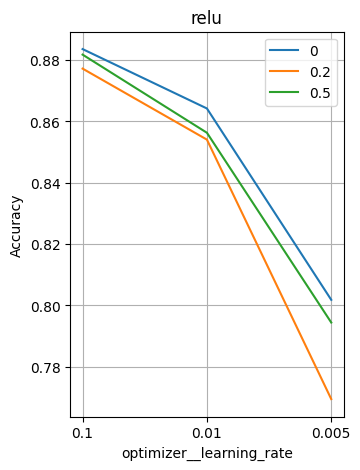

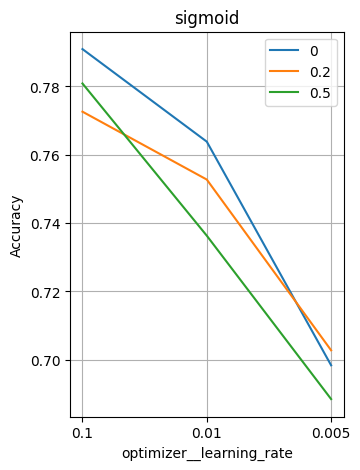

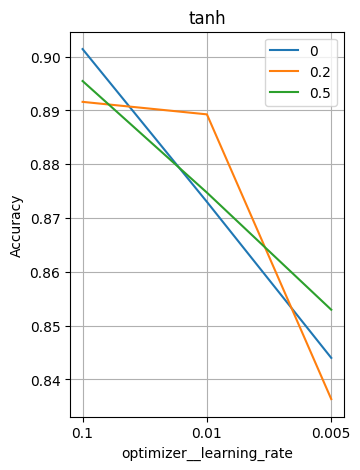

Param combination 1: {'conv_activation': 'relu', 'dropout_rate': 0, 'optimizer__learning_rate': 0.1} took 33.23 seconds in total for 3 CV splits
Param combination 2: {'conv_activation': 'relu', 'dropout_rate': 0, 'optimizer__learning_rate': 0.01} took 28.42 seconds in total for 3 CV splits
Param combination 3: {'conv_activation': 'relu', 'dropout_rate': 0, 'optimizer__learning_rate': 0.005} took 30.65 seconds in total for 3 CV splits
Param combination 4: {'conv_activation': 'relu', 'dropout_rate': 0.2, 'optimizer__learning_rate': 0.1} took 33.03 seconds in total for 3 CV splits
Param combination 5: {'conv_activation': 'relu', 'dropout_rate': 0.2, 'optimizer__learning_rate': 0.01} took 34.13 seconds in total for 3 CV splits
Param combination 6: {'conv_activation': 'relu', 'dropout_rate': 0.2, 'optimizer__learning_rate': 0.005} took 31.50 seconds in total for 3 CV splits
Param combination 7: {'conv_activation': 'relu', 'dropout_rate': 0.5, 'optimizer__learning_rate': 0.1} took 34.52 seco

In [66]:
cnn_param(param_grid)

## Model 3 - Algorithm Choice 1

In [45]:
# Decide the strategy of Cross Validation
cvKFold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [50]:
# Grid Search
def Grid_Search_LR(fun, param_grid):
    model = GridSearchCV(fun, param_grid, cv=cvKFold)
    print("Now testing..."+ type(fun).__name__)
    model.fit(X_train_pca, y_train)
    print("Best params:")
    print(model.best_params_)
    print()
    total_fit_times = [time * cvKFold.get_n_splits() for time in model.cv_results_['mean_fit_time']]
    for i, (params, runtime) in enumerate(zip(model.cv_results_['params'], total_fit_times)):
        print(f"Param combination {i+1}: {params} took {runtime:.2f} seconds in total for {cvKFold.get_n_splits()} CV splits")
    print()
    return model

In [51]:
# Implement Grid Search on LR and plotting
def tune_LR(param_grid):
    model = Grid_Search_LR(LogisticRegression(), param_grid)
    test_score = model.cv_results_["mean_test_score"].reshape(len(param_grid["C"]), -1).T
    for i in range(len(param_grid["penalty"])):
        plt.plot(range(len(param_grid["C"])), test_score[i], label=str(param_grid["penalty"][i]))
    plt.xlabel("The value of C")
    plt.ylabel("Accuracy of each parameters")
    plt.xticks(range(len(param_grid["C"])), param_grid["C"])
    plt.legend()
    plt.grid(True)
    plt.show()

Now testing...LogisticRegression
Best params:
{'C': 0.5, 'penalty': 'l2'}

Param combination 1: {'C': 0.1, 'penalty': 'l2'} took 3.41 seconds in total for 10 CV splits
Param combination 2: {'C': 0.1, 'penalty': 'none'} took 3.35 seconds in total for 10 CV splits
Param combination 3: {'C': 0.5, 'penalty': 'l2'} took 3.30 seconds in total for 10 CV splits
Param combination 4: {'C': 0.5, 'penalty': 'none'} took 3.42 seconds in total for 10 CV splits
Param combination 5: {'C': 4, 'penalty': 'l2'} took 3.35 seconds in total for 10 CV splits
Param combination 6: {'C': 4, 'penalty': 'none'} took 3.35 seconds in total for 10 CV splits
Param combination 7: {'C': 5, 'penalty': 'l2'} took 3.32 seconds in total for 10 CV splits
Param combination 8: {'C': 5, 'penalty': 'none'} took 3.31 seconds in total for 10 CV splits
Param combination 9: {'C': 6, 'penalty': 'l2'} took 3.44 seconds in total for 10 CV splits
Param combination 10: {'C': 6, 'penalty': 'none'} took 3.36 seconds in total for 10 CV spl

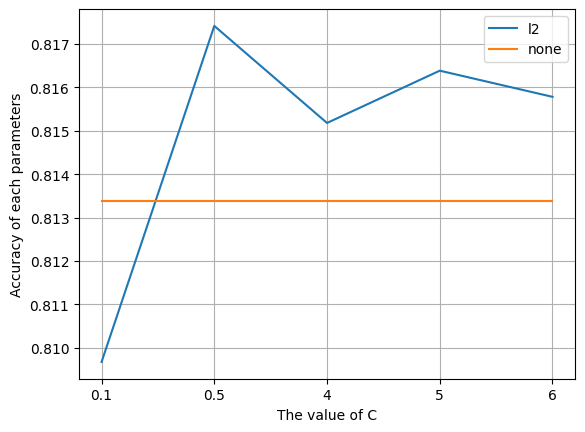

In [52]:
# Get the best params
lr_param_grid = {"penalty":['l2','none'], "C":[0.1, 0.5, 4 ,5 ,6]}
tune_LR(lr_param_grid)

## Model 4 - Algorithm Choice 2

In [67]:
#create cvKFold and splites to 10 fold
cvKFold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [68]:
# create the grid search function
def grid_search(fun, param_grid):
    clf = GridSearchCV(fun, param_grid, cv=cvKFold)
    print("Now Testing..."+ type(fun).__name__)
    clf.fit(X_train, y_train)
    print("Best params:")
    print(clf.best_params_)
    print()
    return clf

In [69]:
# set the Hyperparameter we want to test
param_grid = {
    'n_estimators': [100, 300,500],
    'max_depth': [None, 30, 50],
    'min_samples_split': [2, 5, 8]
    }

In [70]:
# create the Hyperparameter tunning function for randomforest
# That will print the Best params and plot the graph shows use different params accuracy
def rf_param(param_grid):
    start_time = time.time()
    clf = grid_search(RandomForestClassifier(), param_grid)

    test_score = clf.cv_results_["mean_test_score"].reshape(len(param_grid["min_samples_split"]),
                                                         len(param_grid["max_depth"]), -1)
    total_time = time.time() - start_time
    print(f"Total time: {total_time:.2f} seconds")
    for i in range(len(param_grid["min_samples_split"])):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, len(param_grid["min_samples_split"]), i+1)
        score = test_score[i].T
        plt.title(str(param_grid["min_samples_split"][i]))
        for j in range(len(param_grid["n_estimators"])):
            plt.plot(range(len(param_grid['max_depth'])), score[j], label=str(param_grid["n_estimators"][j]))
                 
                 
        plt.xlabel("max_depth")
        plt.ylabel("Accuracy")
        plt.xticks(range(len(param_grid["max_depth"])), param_grid["max_depth"])
        plt.legend()
        plt.grid(True)
        filename = f"cnn_param_grid_{param_grid['min_samples_split'][i]}.png"
        plt.savefig(filename)
    plt.show()
    results_df_rf = pd.DataFrame(clf.cv_results_)
    results_df_rf.to_csv('results_rf.csv', index=False)

Now Testing...RandomForestClassifier
Best params:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}

Total time: 36480.35 seconds


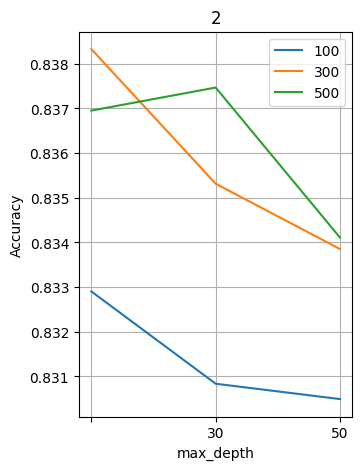

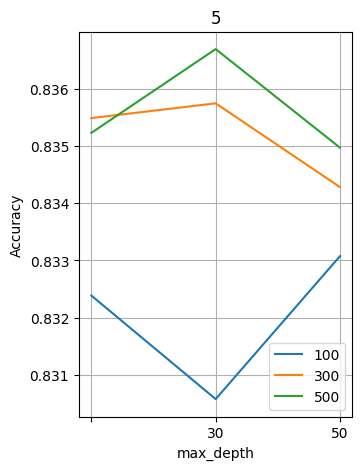

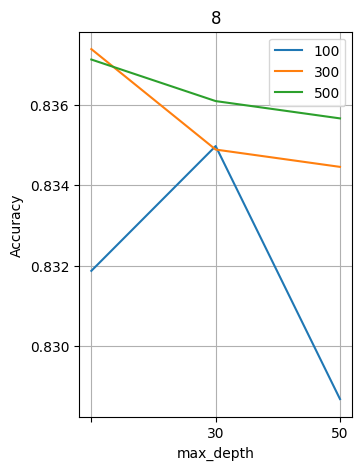

In [71]:
rf_param(param_grid)

# Final Models

## Model 1 - Fully Connected Neural Network

In [46]:
# Best Hyperparameters
best_params = {'activation_function': 'relu', 
               'n_hidden_neurons': 1200, 
               'optimizer__learning_rate': 0.001}

# Defining our final MLP model with only one hidden_layer
MLP_final = keras.models.Sequential([
    keras.layers.Dense(best_params['n_hidden_neurons'], activation=best_params['activation_function']),
    keras.layers.Dense(8, activation="softmax") 
])

opt = keras.optimizers.Adam(learning_rate=best_params['optimizer__learning_rate'])

MLP_final.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [52]:
# Train the final model
start_time = time.time()
history = MLP_final.fit(X_train_pca, y_train, epochs=20,
                    validation_data=(X_valid_pca, y_valid))
runtime = time.time() - start_time
print(f"runtime: {runtime:.2f}s")

Epoch 1/20
364/364 [==============================] - 1s 3ms/step - loss: 8.1443e-06 - accuracy: 1.0000 - val_loss: 0.8273 - val_accuracy: 0.8669
Epoch 2/20
364/364 [==============================] - 1s 3ms/step - loss: 6.6952e-06 - accuracy: 1.0000 - val_loss: 0.8368 - val_accuracy: 0.8693
Epoch 3/20
364/364 [==============================] - 1s 3ms/step - loss: 5.4926e-06 - accuracy: 1.0000 - val_loss: 0.8490 - val_accuracy: 0.8659
Epoch 4/20
364/364 [==============================] - 1s 2ms/step - loss: 4.5053e-06 - accuracy: 1.0000 - val_loss: 0.8647 - val_accuracy: 0.8640
Epoch 5/20
364/364 [==============================] - 1s 3ms/step - loss: 3.7264e-06 - accuracy: 1.0000 - val_loss: 0.8730 - val_accuracy: 0.8674
Epoch 6/20
364/364 [==============================] - 1s 2ms/step - loss: 3.0690e-06 - accuracy: 1.0000 - val_loss: 0.8830 - val_accuracy: 0.8664
Epoch 7/20
364/364 [==============================] - 1s 3ms/step - loss: 2.5427e-06 - accuracy: 1.0000 - val_loss: 0.8924 -

In [59]:
# Evaluate the classifier on the test data.
loss, accuracy = MLP_final.evaluate(X_test_pca, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

107/107 [==============================] - 0s 1ms/step - loss: 0.7050 - accuracy: 0.8815
Test loss: 0.7050
Test accuracy: 0.8815


In [60]:
# Sample several test examples
X_test_pca_samples = X_test_pca[:5]
X_test_original = X_test_sample[:5]
# Get probability of each class from model
y_proba_MLP = MLP_final.predict(X_test_pca_samples).round(2)
print(y_proba_MLP)

1/1 [==============================] - 0s 27ms/step
[[0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.08 0.   0.   0.75 0.   0.18 0.   0.  ]
 [0.   0.   0.   0.99 0.   0.01 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.  ]]


In [47]:
y_pred_MLP = np.argmax(y_proba_MLP, axis=-1)
print(y_pred_MLP)

[1 5 3 6 1]


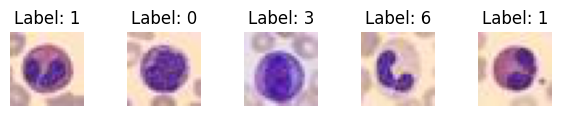

In [48]:
plot_examples_MLP_LR(X_test_original,y_test, n_rows=1, n_cols=5)

## Model 2 - Convolutional Neural Network

In [112]:
#Create the cnn model with the best params
model = keras.Sequential([
    
    # Specify the input shape
    keras.Input(shape=(28, 28, 3)),
    
    # Conv and pool block 1
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="tanh"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Conv and pool block 2
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation="tanh"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten and classify using dense output layer
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, activation="softmax"),
])

# Compile the model
optimizer= Adam(learning_rate=0.005)
model.compile(optimizer= optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 1600)              0         
                                                                 
 dropout_2 (Dropout)         (None, 1600)             

In [113]:
# Create CNN model
def create_cnn_model(pool_type='max', conv_activation='tanh', dropout_rate= 0, learning_rate=0.1 ):
    # create model
    model = keras.Sequential()
    
    # Specify the input shape
    model.add(keras.Input(shape=(28, 28, 3))) 
        
    # Conv and pool block 1
    model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation=conv_activation))  
    if pool_type == 'max': # change the poo_type when do the Hyperparameter tuning
        model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    
    # Conv and pool block 2
    model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation=conv_activation))   
    if pool_type == 'max':
        model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
      
    # Flatten and classify using dense output layer
    model.add(keras.layers.Flatten())         
    model.add(keras.layers.Dense(256, activation='softmax'))
    if dropout_rate != 0:
        model.add(keras.layers.Dropout(rate=dropout_rate))
        
    
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])  
    return model

cnn = create_cnn_model()

In [120]:
# Train the model
start_time = time.time()
es = EarlyStopping(
    monitor='val_loss',  
    patience=10,         
    restore_best_weights=True  
)

batch_size = 128
epochs = 100
history = cnn.fit(X_train_cnn,y_train_cnn, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid_cnn, y_valid_cnn), callbacks=[es])
runtime = time.time() - start_time
print(f"runtime: {runtime:.2f}")

Epoch 1/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0875 - accuracy: 0.9727 - val_loss: 0.2610 - val_accuracy: 0.9152
Epoch 2/100
91/91 [==============================] - 0s 3ms/step - loss: 0.0876 - accuracy: 0.9727 - val_loss: 0.2643 - val_accuracy: 0.9161
Epoch 3/100
91/91 [==============================] - 0s 3ms/step - loss: 0.0920 - accuracy: 0.9711 - val_loss: 0.2919 - val_accuracy: 0.9147
Epoch 4/100
91/91 [==============================] - 0s 3ms/step - loss: 0.0804 - accuracy: 0.9770 - val_loss: 0.2747 - val_accuracy: 0.9147
Epoch 5/100
91/91 [==============================] - 0s 3ms/step - loss: 0.0803 - accuracy: 0.9767 - val_loss: 0.2721 - val_accuracy: 0.9196
Epoch 6/100
91/91 [==============================] - 0s 3ms/step - loss: 0.0753 - accuracy: 0.9775 - val_loss: 0.2658 - val_accuracy: 0.9210
Epoch 7/100
91/91 [==============================] - 0s 3ms/step - loss: 0.0757 - accuracy: 0.9774 - val_loss: 0.2898 - val_accuracy: 0.9098
Epoch 8/100
9

In [121]:
# Evaluate the classifier on the test data.
loss, accuracy = cnn.evaluate(X_train_cnn,y_train_cnn)
print(f"Accuracy on test data: {accuracy:.4f}")

364/364 [==============================] - 0s 1ms/step - loss: 0.0549 - accuracy: 0.9884
Accuracy on test data: 0.9884


In [116]:
X_test_cnn_samples = X_test_cnn[:5]
y_proba_cnn = cnn.predict(X_test_cnn_samples)
print(y_proba_cnn)

1/1 [==============================] - 0s 36ms/step
[[2.0442080e-06 9.9999714e-01 1.8449352e-20 ... 1.9564126e-16
  1.2690673e-15 5.8722025e-16]
 [9.6955925e-01 1.8880756e-03 1.1444171e-16 ... 6.1926403e-14
  1.3511840e-13 1.7648326e-13]
 [2.9459969e-07 3.4712709e-04 1.5325737e-09 ... 5.0683131e-14
  8.3954877e-14 8.4523019e-14]
 [3.1762905e-04 2.3394046e-04 3.5145320e-10 ... 4.5968306e-11
  4.7962946e-11 1.3348948e-10]
 [1.5248267e-07 9.9999976e-01 2.4700300e-18 ... 3.4003671e-17
  7.2907143e-17 2.3888913e-17]]


In [117]:
y_pred_cnn = np.argmax(y_proba_cnn, axis=-1)
print(y_pred_cnn)

[1 0 3 6 1]


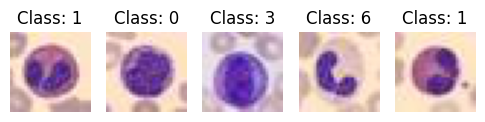

In [111]:
plot_cnn(X_test_cnn ,y_test, n_rows=1, n_cols=5)

## Model 3 - Algorithm Choice 1

In [50]:
# Train the final model
start_time = time.time()
LR_Final = LogisticRegression(penalty="l2",C=0.5)
LR_Final.fit(np.concatenate((X_train_pca, X_valid_pca)), np.concatenate((y_train, y_valid)))
print(f"The accuracy of best LR is {LR_Final.score(X_test_pca, y_test):.4f}")
runtime = time.time() - start_time
print(f"runtime: {runtime:.2f}s")

The accuracy of best LR is 0.8222
runtime: 0.93s


In [145]:
y_proba_LR = LR_Final.predict_proba(X_test_pca_samples).round(2)
print(y_proba_LR)

[[0.   0.97 0.   0.   0.   0.   0.03 0.  ]
 [0.03 0.43 0.   0.   0.   0.01 0.53 0.  ]
 [0.   0.   0.   0.56 0.02 0.41 0.   0.  ]
 [0.   0.   0.05 0.   0.   0.69 0.26 0.  ]
 [0.   0.52 0.   0.   0.   0.   0.48 0.  ]]


In [146]:
y_pred_LR = np.argmax(y_proba_LR, axis=-1)
print(y_pred_LR)

[1 6 3 5 1]


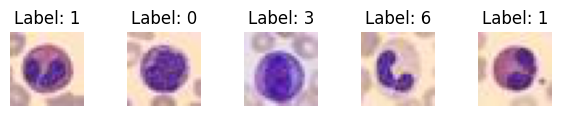

In [147]:
plot_examples_MLP_LR(X_test_original,y_test, n_rows=1, n_cols=5)

## Model 4 - Algorithm Choice 2

In [39]:
# create the model with the best params and train model to print the accuracy
start_time = time.time()
rnd_clf = RandomForestClassifier(n_estimators=300,  max_depth = None, min_samples_split= 2)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
print("Random forest ensemble - accuracy on test set:")
print(accuracy_score(y_test, y_pred_rf))
runtime = time.time() - start_time
print(f"runtime: {runtime:.2f}s")

Random forest ensemble - accuracy on test set:
0.8373793506873355
runtime: 136.90s


In [40]:
print(y_pred_rf[:5])

[1 3 3 6 1]


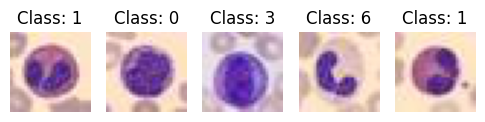

In [42]:
plot_cnn(X_test_cnn,y_test, n_rows=1, n_cols=5)